# Soil Layering by Cone Penetration Test Data

This notebook aims to explore various machine learning approaches to automatically determine soil stratification based on CPT data.
Author: Zhiyan Jiang (linkedIn.com/zhiyanjiang)

In [1]:
import warnings
warnings.simplefilter("ignore") # default

#%matplotlib inline

In [2]:
# import external libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
import pickle
import io

# import internal libraries
from constants import PSF2TSF, PA2TSF, PSI2TSF
from importData import *
from plotCPT import *
from plot import *


## Step 1: configurations 

In [3]:
cptFileName = "..\\Data\\NSF\\4_5.csv"
gwtFileName = "..\\Data\\GWT data.csv"
SBTnImgFileName = '.\\Images\\SBTn_background.jpg'

# Include multiple cptFileNames to the list, if needed
cptFileNames = [cptFileName] #, "..\\Data\\NSF\\981.csv"]

# Clustering parameters
randomState = None # 0 or # None, i.e. time.time()
numberClusters = 4

# CPT-specific parameters
# area ratio
an = 0.88

# Assume uniform unit weight
soilUnitWeight = 120 # unit shall be pcf
waterUnitWeight = 62.4 # unit shall be pcf

# Applying filtering, unit of feet
# Purpose: to remove consecutive peaks
windowLength = 3
# Repeating filtering. Default = 1
filterTimes = 1  

# Remove peaks
removePeaksFlag = False

## Step 2: Import data, averaging, and removing spikes.

Row number is: 4866, and Column number is: 4


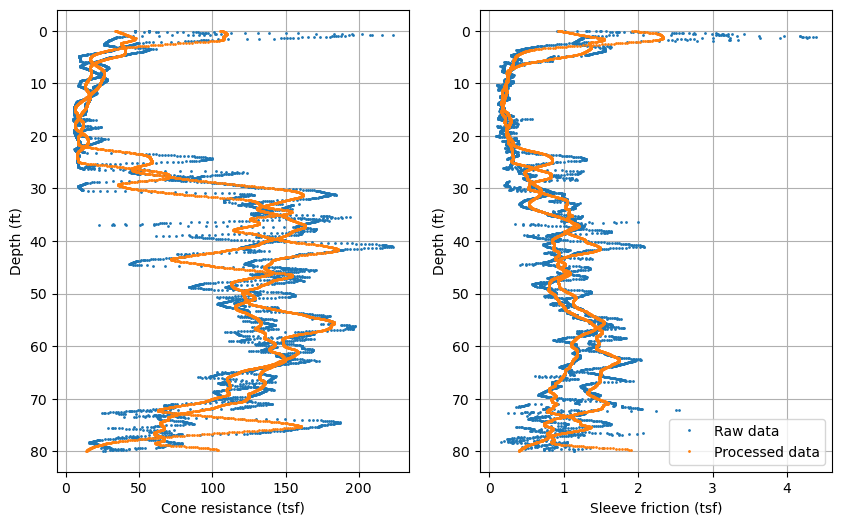

In [4]:
# Import data and apply filtering
plotImportFlag = True
rawData = importCPTs(cptFileNames,  windowLength, filterTimes,removePeaksFlag, plotImportFlag)

# Import GWT data
gwtData = importGWT(gwtFileName)

# Backup rawData
rawDataCopy = rawData.copy()

## Step 3: Pre-processing

In [5]:
# Need to sort data in terms of depth
from processCPT import * 
# Correct cone resistance to get tip resistance
data = pd.DataFrame(columns = ["Depth (ft)", "Tip resistance (tsf)", "Sleeve friction (tsf)"])

data["Depth (ft)"] = rawData.iloc[:, 0]
data["Tip resistance (tsf)"] = rawData.iloc[:, 1]

data["Tip resistance (tsf)"] = rawData.iloc[:, 1]
if rawData.shape[1] > 3: # rawData has pore pressure
    data["Tip resistance (tsf)"] += (1-an) * rawData.iloc[:, 3] * PSI2TSF


data["Sleeve friction (tsf)"] = rawData.iloc[:, 2]

depth = data["Depth (ft)"].to_frame()

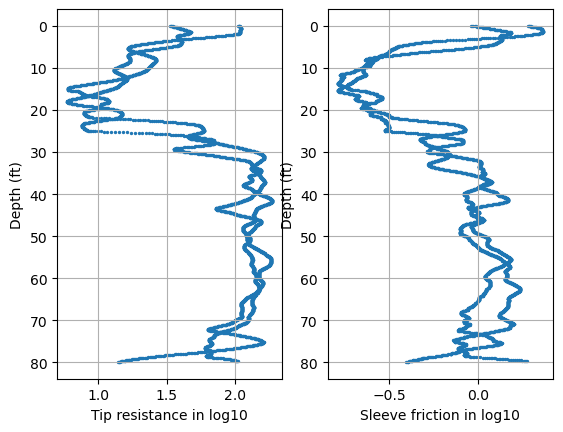

In [6]:
# Prepare data in log-scale
dataLog = data.copy()
dataLog.iloc[:,1:] = np.log10(dataLog.iloc[:,1:])
dataLog.columns =  ["Depth (ft)", "Tip resistance in log10", "Sleeve friction in log10"]


dataLogAxes = plotAggregate(dataLog, labels = dataLog.columns, markerSize = 2, axes  = None)

## 3.1 Sort

In [7]:
# PLACE HOLDER

## 3.2 Calculate derived CPT parameters

The equation for normalized soil behavior type can be found in: <br>
Robertson, P.K. Guide to Cone Penetration Testing, 6th Ed., 2015 <br>
<br>
<img src = ".\Images\SBTn_equation.jpg" width = 400>

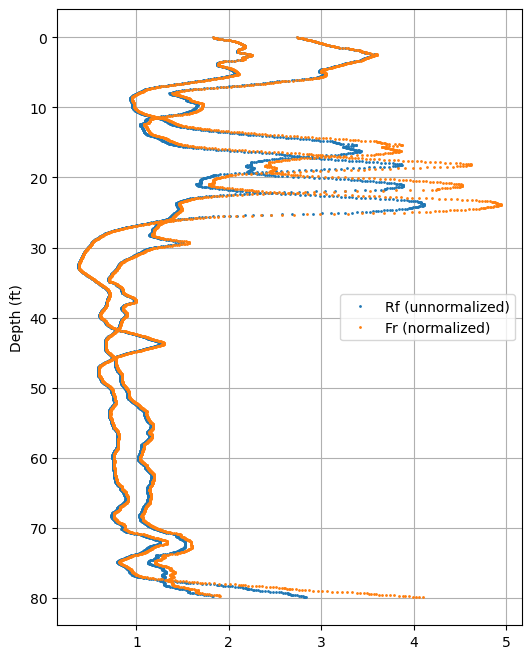

In [8]:
# Calculate friciton ratio
Rf = calculateRf(data.iloc[:,1], data.iloc[:,2])

# calculate normalized friction ratio
Fr = calculateFr(data.iloc[:,0].to_frame(), data.iloc[:,1].to_frame(), data.iloc[:,2].to_frame(), soilUnitWeight)

plotRfFr(depth, Rf, Fr)


Qtn converged in 4 times


Text(0.5, 0, 'Tip resistance')

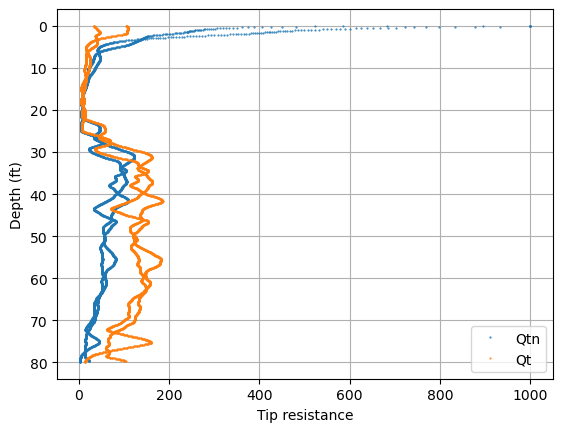

In [9]:
# Calculate stresses
sigma_vo = calculateSigma_vo(data.iloc[:,0].to_frame(), soilUnitWeight)

hydroStaticPressure = calculateHydroStaticPressure(data.iloc[:, 0].to_frame(), gwtData.iloc[0,0], waterUnitWeight)

sigma_vo_prime = (sigma_vo.iloc[:,0] - hydroStaticPressure.iloc[:,0]).to_frame()

# calculate Qtn
Qtn = iterateQtn(depth, data.iloc[:,1].to_frame(), Fr, gwtData.iloc[0,0], soilUnitWeight, waterUnitWeight, PA2TSF)
plt.plot(Qtn, depth, linestyle = '', marker = '.', markersize = 1)
plt.gca().invert_yaxis()
plt.plot(data.iloc[:,1], data.iloc[:,0], linestyle = '', marker = '.', markersize = 1)
plt.legend(["Qtn", "Qt"])
plt.grid(True)
plt.ylabel("Depth (ft)")
plt.xlabel("Tip resistance")

In [10]:
# Calculate and plot NORMALIZED Soil behavior type Index
Ic = calculateIc(Qtn, Fr)


## Step 4: Clustering

## 4.1 Decision Tree

In [11]:
from performDecisionTreeClustering import *

### 4.1.1 Decision Tree on log of [tip resistance, sleeve friction]

The score by Decision tree regression: 0.7923484234428955
The layer interface depths resulting from Decision tree method is below:
   Decision Tree Criteria
0                4.839239
1               22.621390
2               26.295932

Below is the results by Decision tree regression


array([<Axes: xlabel='Tip resistance in log10', ylabel='Depth (ft)'>,
       <Axes: xlabel='Sleeve friction in log10', ylabel='Depth (ft)'>],
      dtype=object)

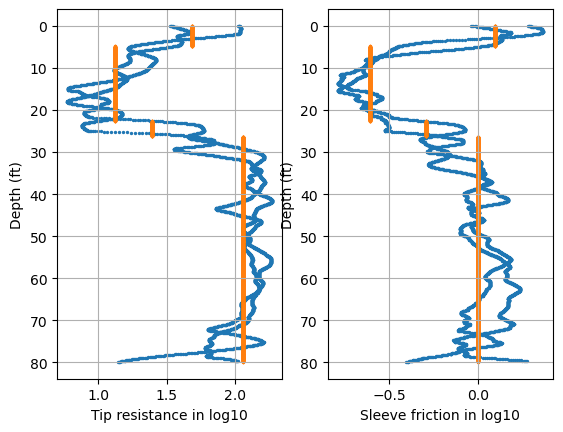

In [12]:
# Perform decisiontree regression on [tip resistance, sleeve friction]
performDecisionTreeFlag = "regression"
decisionTreeInput = [dataLog, numberClusters, randomState]
decisionTreeObj, decisionTreeResult = performDecisionTree(performDecisionTreeFlag, decisionTreeInput)

# Extract decisionTreeCriteria
decisionTreeCriteria = getDecisionTreeCriteria(decisionTreeObj)
print(f"The layer interface depths resulting from Decision tree method is below:")
print(decisionTreeCriteria)
print()

# plot decision tree results 
dataLogAxes = plotAggregate(dataLog, labels = dataLog.columns, markerSize = 2, axes  = None)
plotDecisionTreeResult(decisionTreeResult, dataLog, axes = dataLogAxes)


### 4.1.2 Decision Tree on Ic

The score by Decision tree regression: 0.6668726596924246
The layer interface depths resulting from Decision tree method is below:
   Decision Tree Criteria
0               12.942913
1               26.197507
2               69.832680

Below is the results by Decision tree regression


[<Axes: title={'center': 'Histogram of Ic'}, xlabel='Ic', ylabel='Count'>]

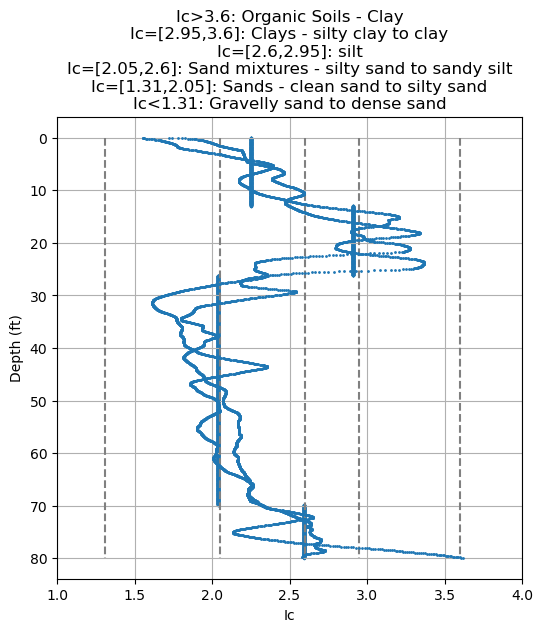

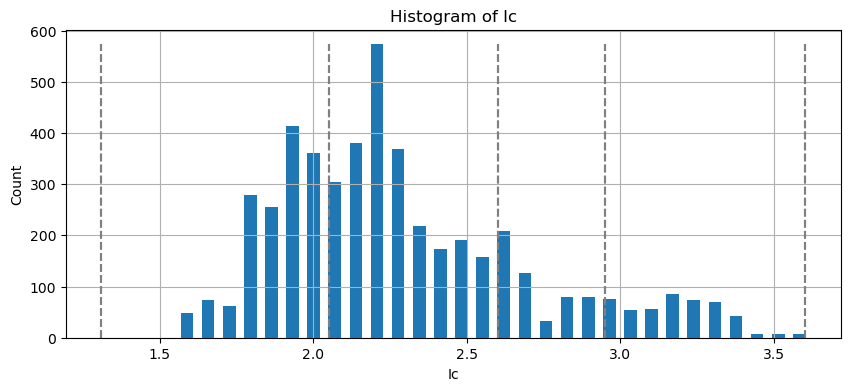

In [13]:
# Perform decision tree on Ic
dataIc = pd.concat([data.iloc[:,0], Ic], axis = 1) 
performDecisionTreeFlag = "regression"
decisionTreeInput = [dataIc, numberClusters, randomState]
decisionTreeObj, decisionTreeResult = performDecisionTree(performDecisionTreeFlag, decisionTreeInput)

# Extract decisionTreeCriteria
decisionTreeCriteria = getDecisionTreeCriteria(decisionTreeObj)
print(f"The layer interface depths resulting from Decision tree method is below:")
print(decisionTreeCriteria)
print()

# plot decision tree results 
IcAxes = plotIc(data.iloc[:,0].to_frame(), Ic)
plotDecisionTreeResult(decisionTreeResult, dataIc, IcAxes)

# Plot Ic histogram
IcHistogramAxes = plotIcHistogram(Ic)
IcCounts, _ = np.histogram(Ic, bins = 30)

# Plot Icthreshold
plotIcThreadholds(np.max(IcCounts), IcHistogramAxes)

#IcAxes[0].figure

### 4.1.3 Decision tree on SBTn type

Infer soil behavior type based on SBTn type, then apply decision tree

In [14]:
# Obtain sbtn
dataSBTn1D = calculateSBTn1D(dataIc)

4866


The score by Decision tree regression: 0.6623510069872586
The layer interface depths resulting from Decision tree method is below:
   Decision Tree Criteria
0               12.647637
1               27.772309
2               62.483595

Below is the results by Decision tree regression


[<Axes: title={'center': 'Ic>3.6: Organic Soils - Clay\nIc=[2.95,3.6]: Clays - silty clay to clay\nIc=[2.6,2.95]: silt\nIc=[2.05,2.6]: Sand mixtures - silty sand to sandy silt\nIc=[1.31,2.05]: Sands - clean sand to silty sand\nIc<1.31: Gravelly sand to dense sand'}, xlabel='Ic', ylabel='Depth (ft)'>]

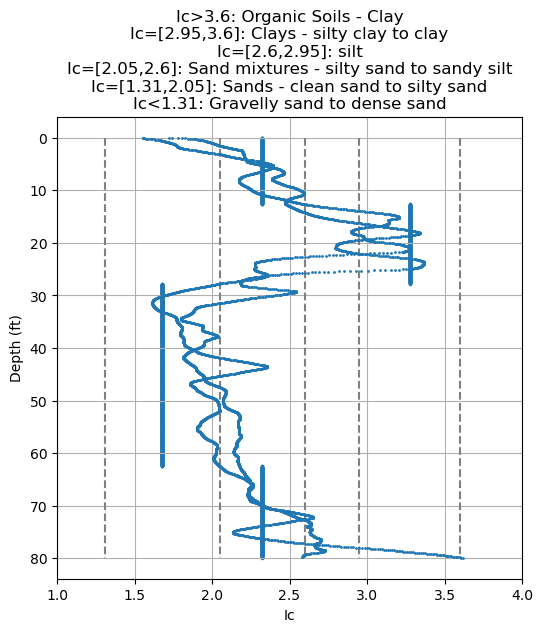

In [15]:
# Perform decisiontree regression on SBTn
performDecisionTreeFlag = "classification" # when using SBTn, must use "classification"

decisionTreeInput = [dataSBTn1D, numberClusters, randomState]
decisionTreeObj, decisionTreeResult = performDecisionTree(performDecisionTreeFlag, decisionTreeInput)

# Extract decisionTreeCriteria
decisionTreeCriteria = getDecisionTreeCriteria(decisionTreeObj)
print(f"The layer interface depths resulting from Decision tree method is below:")
print(decisionTreeCriteria)
print()

# plot decision tree results 
IcAxes = plotIc(data.iloc[:,0].to_frame(), Ic)
# Obtain SBTn corresponded middle Ic value
decisionTreeResultSBTn1DIc = calculateSBTn1DIc(decisionTreeResult) 
plotDecisionTreeResult(decisionTreeResultSBTn1DIc, dataIc, IcAxes)


## 4.2 Random Forest

In [16]:
# Perform Random Forest
from performRandomForestClustering import *

### 4.2.1 Perform random forest regression on log [tip resistance, sleeve friction]

Use Random Forest regressor.
The score by Random Forest: 0.808092220155108
Below is the results by Random forest regression


array([<Axes: xlabel='Tip resistance in log10', ylabel='Depth (ft)'>,
       <Axes: xlabel='Sleeve friction in log10', ylabel='Depth (ft)'>],
      dtype=object)

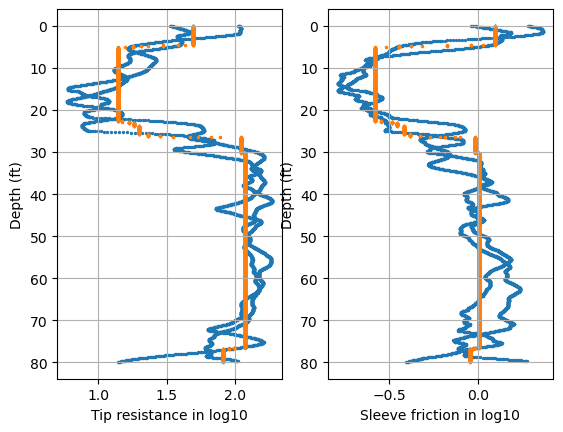

In [17]:
# Perform Random Forest on log of [Tip resistance, sleeve friction]

performRandomForestFlag = "regression"
numberTrees = 10
maxLeafNodes = numberClusters
randomForestInput = [dataLog, numberTrees, maxLeafNodes, randomState]

randomForestObj, randomForestResult = performRandomForest(performRandomForestFlag, randomForestInput)

# plot random forest result
dataLogAxes = plotAggregate(dataLog, labels = dataLog.columns, markerSize = 2, axes  = None)
plotRandomForestResult(randomForestResult, dataLog, dataLogAxes)


The reduced Random Forest criteria by median is: 
0     4.708005
1    24.753937
2    28.313648
dtype: float64
The reduced Random Forest criteria by majority is: 
        Random Forest Criteria 1D
Labels                           
2                        4.744095
0                       25.508530
1                       76.599409


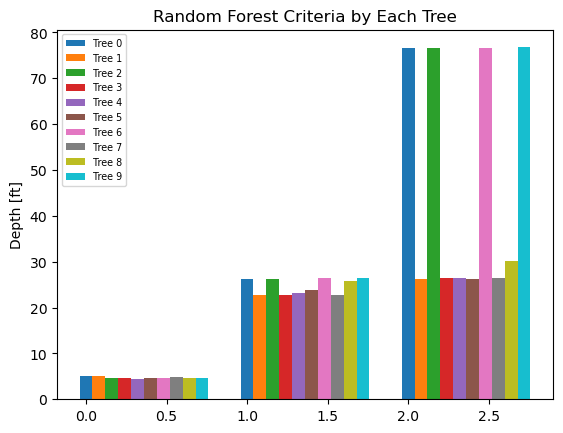

In [18]:
# Extract layer interface depths from non-leaf nodes
randomForestCriteria = getRandomForestCriteria(randomForestObj)

# plot results by each tree using bar chart
plotRandomForestCriteria(randomForestCriteria)

# reduce randomForestCriteria as median
randomForestCriteriaReduced = randomForestCriteriaMedian(randomForestCriteria)
print(f"The reduced Random Forest criteria by median is: \n{randomForestCriteriaReduced}")

# reduce randomForestCriteria as majority
randomForestCriteriaReduced = randomForestCriteriaMajority(randomForestCriteria)
print(f"The reduced Random Forest criteria by majority is: \n{randomForestCriteriaReduced}")

Senstivity analysis on number of layers, i.e., number of leaf nodes

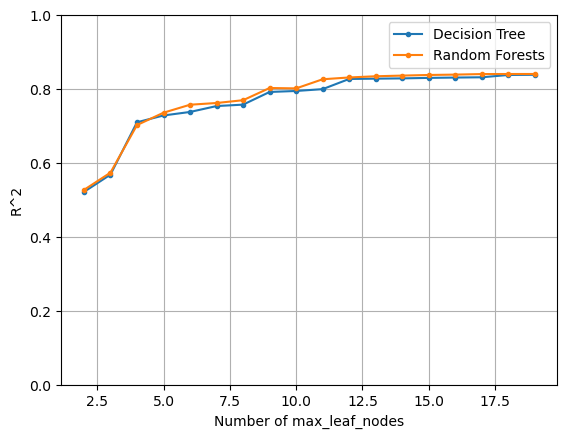

In [19]:
# test multiple max_leaf_nodes
from testMaxLeafNodes import *

testDecisionTreeFlag = "regression"
testRandomForestFlag =  "regression"
testObjFlags = [testDecisionTreeFlag, testRandomForestFlag]
leafNodesRange = [2, 20]

testMaxLeafNodes(leafNodesRange, testObjFlags, data)

Notes: If only a limit number of CPT soundings is used, need to avoid overfitting.

Plot random forest results on Peter Robertson Soil Behavior Type Chart

array([<Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>,
       <Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>,
       <Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>,
       <Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>],
      dtype=object)

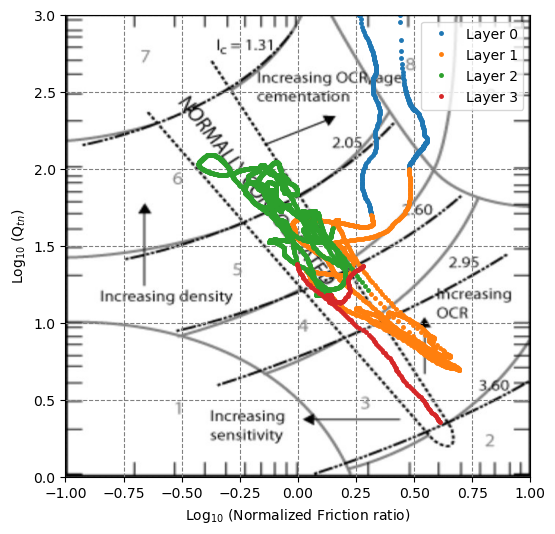

<Figure size 640x480 with 0 Axes>

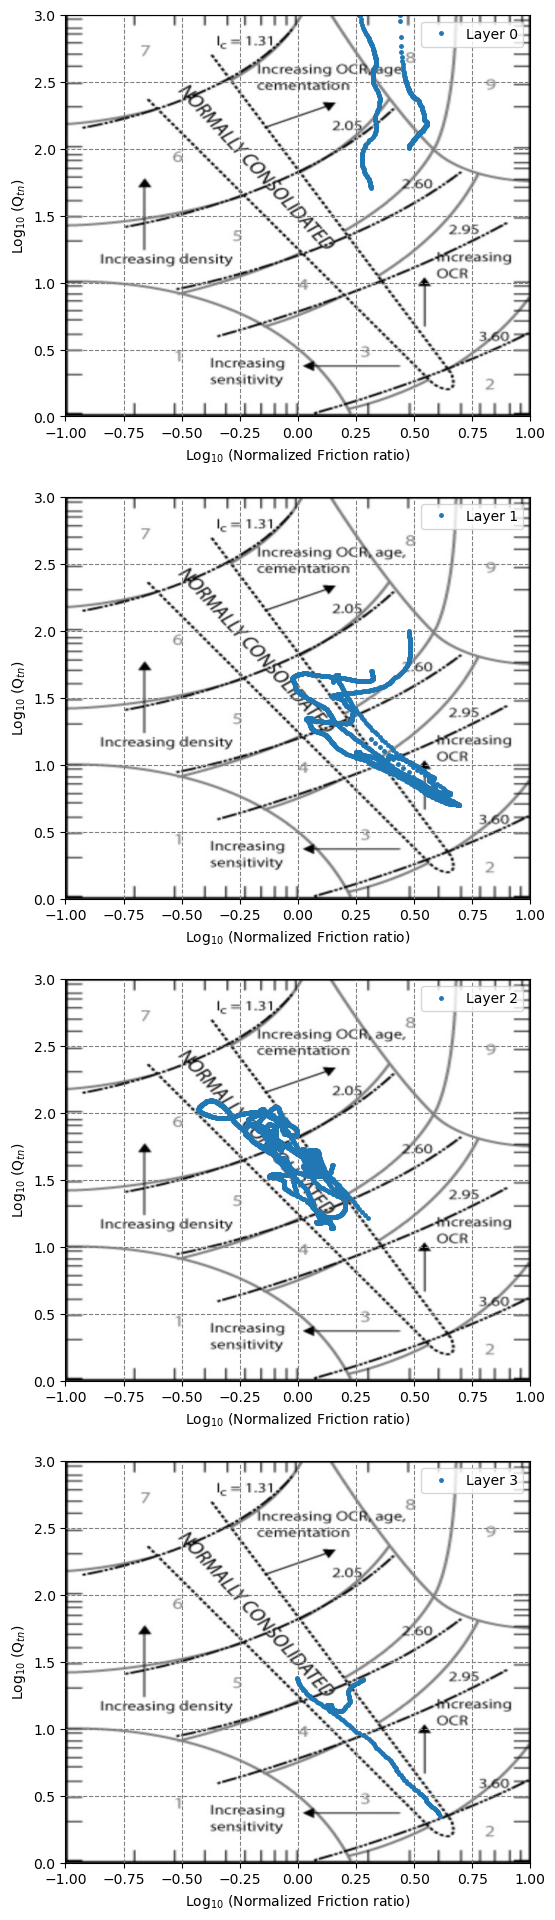

In [20]:
from applyCriteria import *

# Get strata index of each data point
randomForestStrataIndex = getStrataIndex(randomForestCriteriaReduced, data)

# Plot strataIndex on soil behavior type chart

plotSBTnAllinOne(Fr, Qtn, numberClusters, randomForestStrataIndex, SBTnImgFileName)
plt.figure()
plotSBTnAllinAll(Fr, Qtn, numberClusters, randomForestStrataIndex, SBTnImgFileName)

### 4.2.2 Perform random forest regression on Ic 

Use Random Forest regressor.
The score by Random Forest: 0.6714562419411003
Below is the results by Random forest regression

The reduced Random Forest criteria by median is: 
0    12.877296
1    26.164699
2    69.849083
dtype: float64

The reduced Random Forest criteria by majority is: 
        Random Forest Criteria 1D
Labels                           
0                       12.874016
2                       26.166339
1                       69.858924


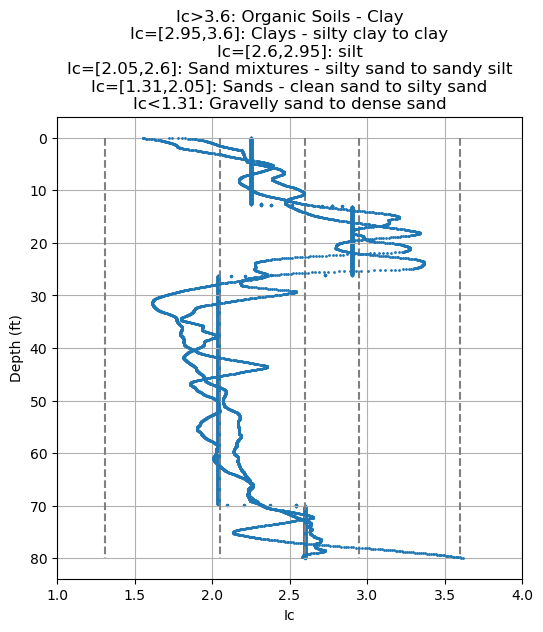

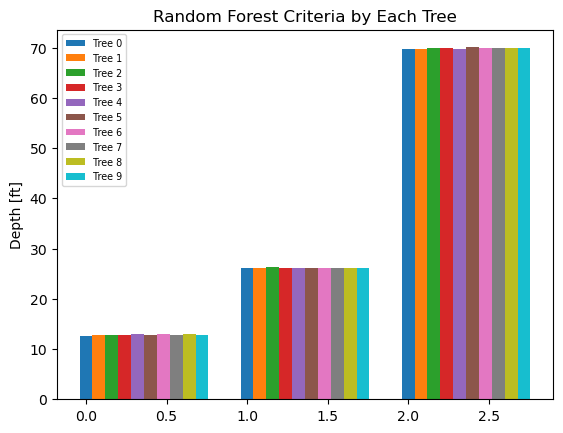

In [21]:
# Perform Random Forest on Ic
performRandomForestFlag = "regression"
numberTrees = 10
maxLeafNodes = numberClusters
randomForestInput = [dataIc, numberTrees, maxLeafNodes, randomState]

randomForestObj, randomForestResult = performRandomForest(performRandomForestFlag, randomForestInput)

# plot random forest result
IcAxes = plotIc(data.iloc[:,0].to_frame(), Ic)
plotRandomForestResult(randomForestResult, dataIc, IcAxes)

# Extract layer interface depths from non-leaf nodes
randomForestCriteria = getRandomForestCriteria(randomForestObj)

# plot results by each tree using bar chart
plt.figure()
plotRandomForestCriteria(randomForestCriteria)

# reduce randomForestCriteria as median
randomForestCriteriaReduced = randomForestCriteriaMedian(randomForestCriteria)
print()
print(f"The reduced Random Forest criteria by median is: \n{randomForestCriteriaReduced}")

# reduce randomForestCriteria as majority
print()
randomForestCriteriaReduced = randomForestCriteriaMajority(randomForestCriteria)
print(f"The reduced Random Forest criteria by majority is: \n{randomForestCriteriaReduced}")


Senstivity analysis on number of layers, i.e., number of leaf nodes

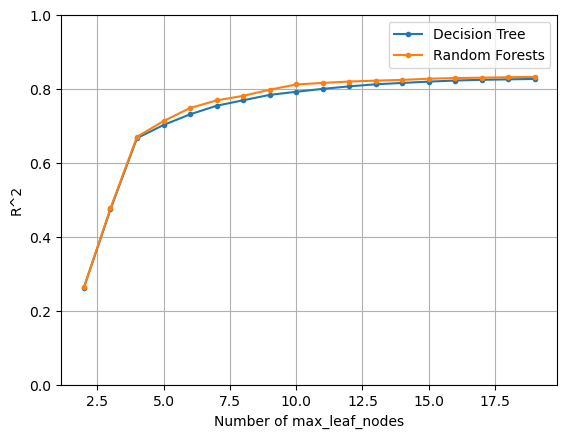

In [22]:
# test multiple max_leaf_nodes
from testMaxLeafNodes import *

testDecisionTreeFlag = "regression"
testRandomForestFlag = "regression"
testObjFlags = [testDecisionTreeFlag, testRandomForestFlag]
leafNodesRange = [2, 20]

testMaxLeafNodes(leafNodesRange, testObjFlags, dataIc)

Plot random forest results on Peter Robertson Soil Behavior Type Chart

array([<Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>,
       <Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>,
       <Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>,
       <Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>],
      dtype=object)

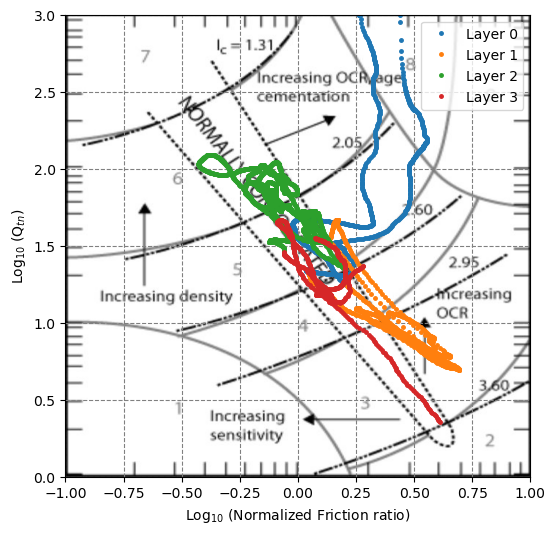

<Figure size 640x480 with 0 Axes>

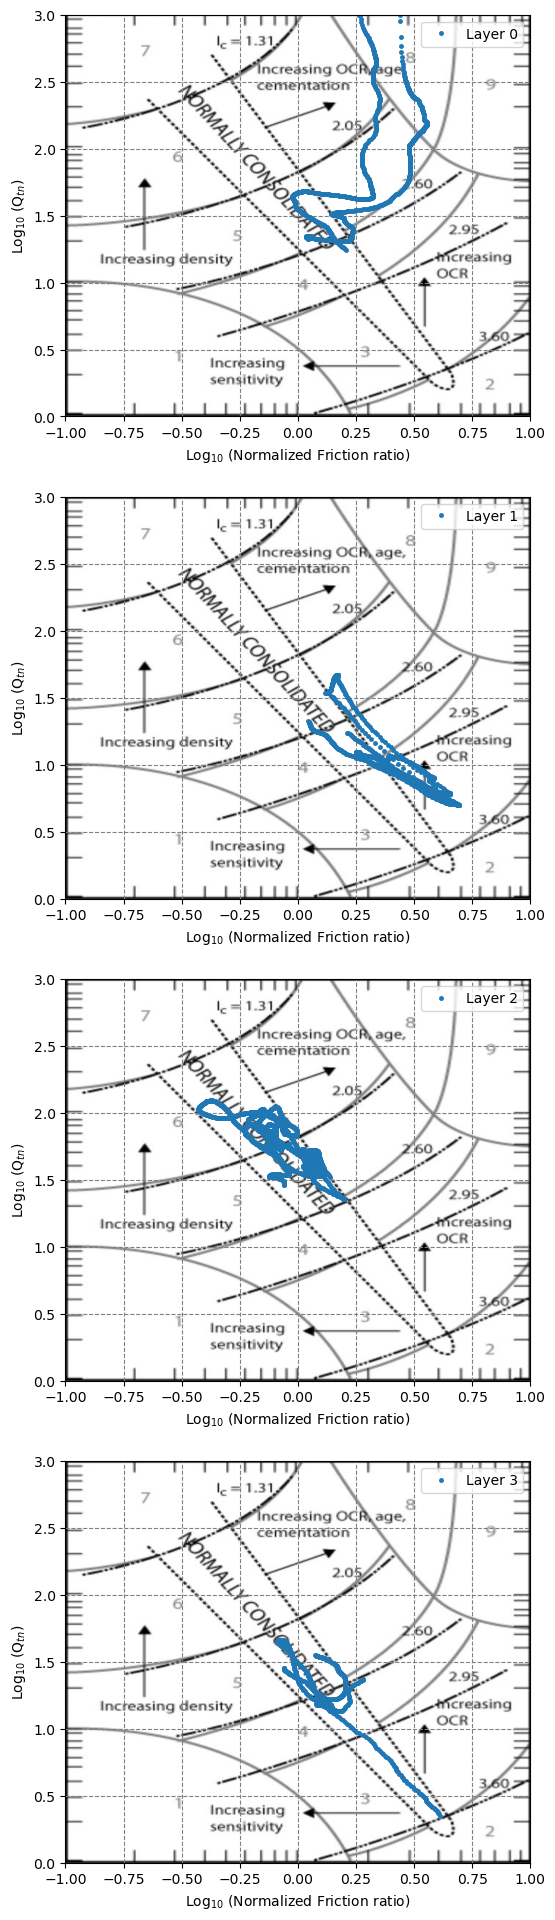

In [23]:
from applyCriteria import *

# Get strata index of each data point
randomForestStrataIndex = getStrataIndex(randomForestCriteriaReduced, dataIc)

plotSBTnAllinOne(Fr, Qtn, numberClusters, randomForestStrataIndex, SBTnImgFileName)
plt.figure()
plotSBTnAllinAll(Fr, Qtn, numberClusters, randomForestStrataIndex, SBTnImgFileName)

### 4.2.3 Perform random forest regression on Ic-correlated SBTn 

Use Random Forest classifier.
The score by Random Forest: 0.666255651459104
Below is the results by Random forest regression

The reduced Random Forest criteria by median is: 
0    12.860892
1    27.788713
2    62.483595
dtype: float64

The reduced Random Forest criteria by majority is: 
        Random Forest Criteria 1D
Labels                           
2                       12.942913
0                       28.042979
1                       62.442585


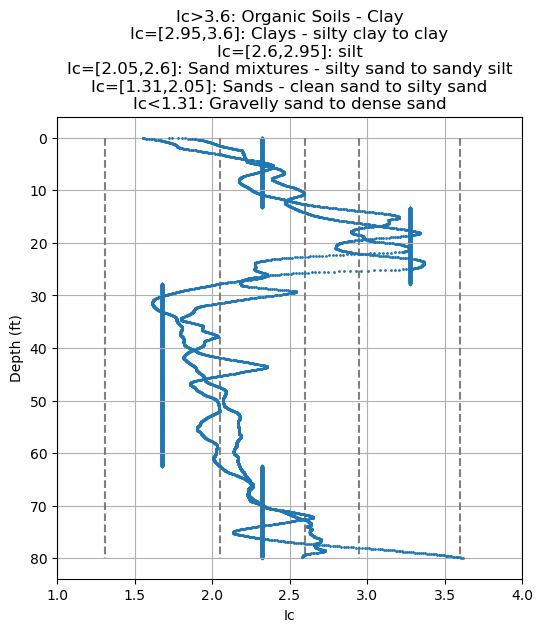

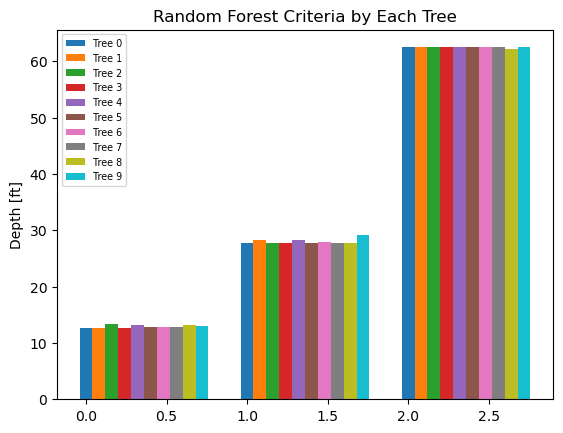

In [24]:
# Perform random forest regressino on SBTn
performRandomForestFlag = "classification" # when using SBTn, must use "classification"
numberTrees = 10
maxLeafNodes = numberClusters
randomForestInput = [dataSBTn1D, numberTrees, maxLeafNodes, randomState]

randomForestObj, randomForestResult = performRandomForest(performRandomForestFlag, randomForestInput)

# plot random forest result
IcAxes = plotIc(data.iloc[:,0].to_frame(), Ic)
randomForestResultSBTn1DIc = calculateSBTn1DIc(randomForestResult) 
plotRandomForestResult(randomForestResultSBTn1DIc, dataSBTn1D, IcAxes)

# Extract layer interface depths from non-leaf nodes
randomForestCriteria = getRandomForestCriteria(randomForestObj)

# plot results by each tree using bar chart
plt.figure()
plotRandomForestCriteria(randomForestCriteria)

# reduce randomForestCriteria as median
randomForestCriteriaReduced = randomForestCriteriaMedian(randomForestCriteria)
print()
print(f"The reduced Random Forest criteria by median is: \n{randomForestCriteriaReduced}")

# reduce randomForestCriteria as majority
print()
randomForestCriteriaReduced = randomForestCriteriaMajority(randomForestCriteria)
print(f"The reduced Random Forest criteria by majority is: \n{randomForestCriteriaReduced}")

array([<Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>,
       <Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>,
       <Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>,
       <Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>],
      dtype=object)

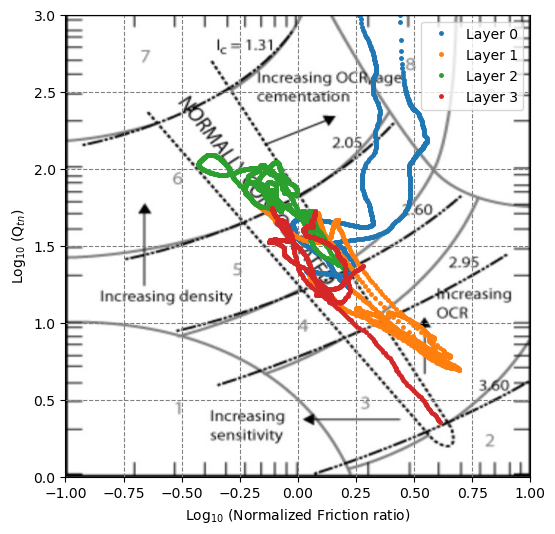

<Figure size 640x480 with 0 Axes>

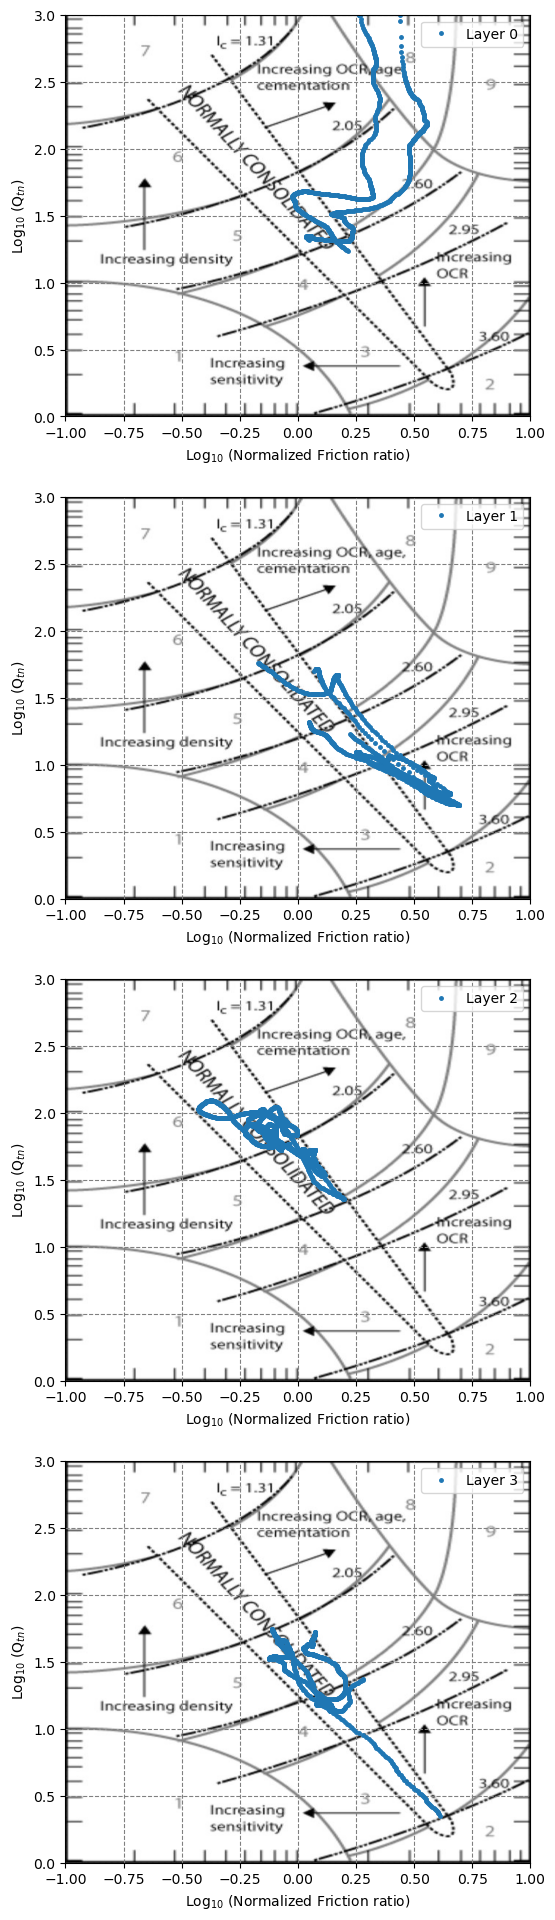

In [25]:
# Get strata index of each data point
randomForestStrataIndex = getStrataIndex(randomForestCriteriaReduced, dataIc)

plotSBTnAllinOne(Fr, Qtn, numberClusters, randomForestStrataIndex, SBTnImgFileName)
plt.figure()
plotSBTnAllinAll(Fr, Qtn, numberClusters, randomForestStrataIndex, SBTnImgFileName)

## 4.3 Agglomerative Clustering

In [26]:
# PLACE HOLDER

## 4.4 Clustering based on 2D SBTn chart

In [27]:
import shapely
from shapely.geometry import Point, Polygon
print("External package Shapely is loaded. Version:")
print(shapely.__version__)


External package Shapely is loaded. Version:
2.0.7


In [28]:
# Load digitized shape file
SBTnShapeFile = "..\\Digitize SBTn chart\\SBTn zone shapes.csv"

SBTnShapeData = importSBTnChart(SBTnShapeFile)

SBTnShapeCoords = digitizeSBTnChart(SBTnShapeData)

To verify SBTn2D, Points in each zone shall have the same color.


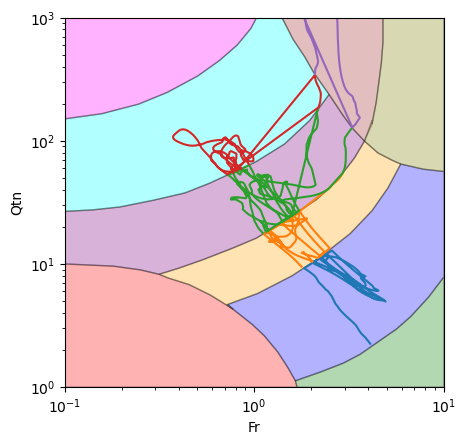

In [29]:
# Determine SBTn 2D zone index for each point
SBTn2D = calculateSBTn2D(Fr, Qtn,  SBTnShapeCoords)

# Verify SBTn2D
verifySBTn2D(Fr, Qtn, SBTn2D, SBTnShapeCoords)

dataSBTn2D = pd.concat([depth, SBTn2D], axis = 1)


Use Random Forest classifier.
The score by Random Forest: 0.6196054254007398
Below is the results by Random forest regression

The reduced Random Forest criteria by median is: 
0    27.739501
1    62.573820
2    71.415682
dtype: float64

The reduced Random Forest criteria by majority is: 
        Random Forest Criteria 1D
Labels                           
0                       25.411472
2                       62.577101
1                       71.483349


array([<Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>,
       <Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>,
       <Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>,
       <Axes: xlabel='Log$_{10}$ (Normalized Friction ratio)', ylabel='Log$_{10}$ (Q$_{tn}$)'>],
      dtype=object)

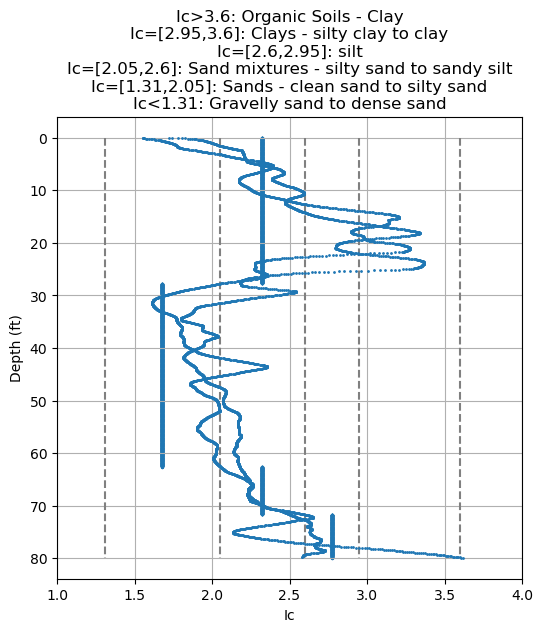

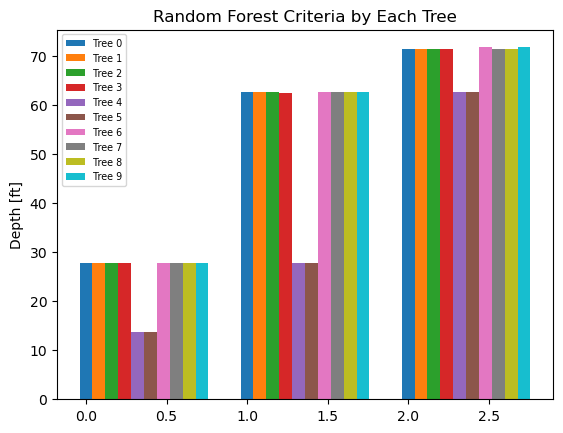

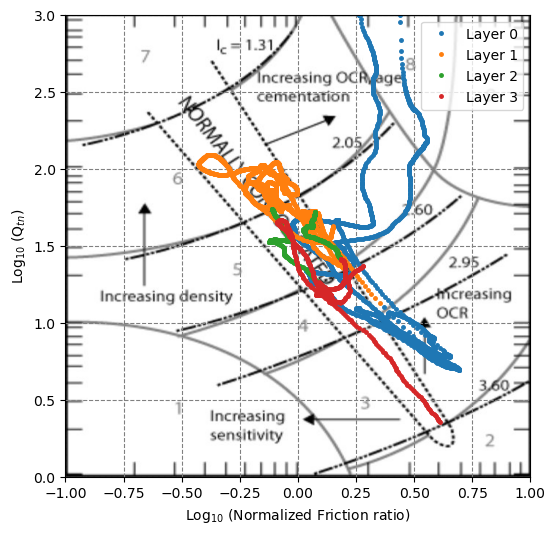

<Figure size 640x480 with 0 Axes>

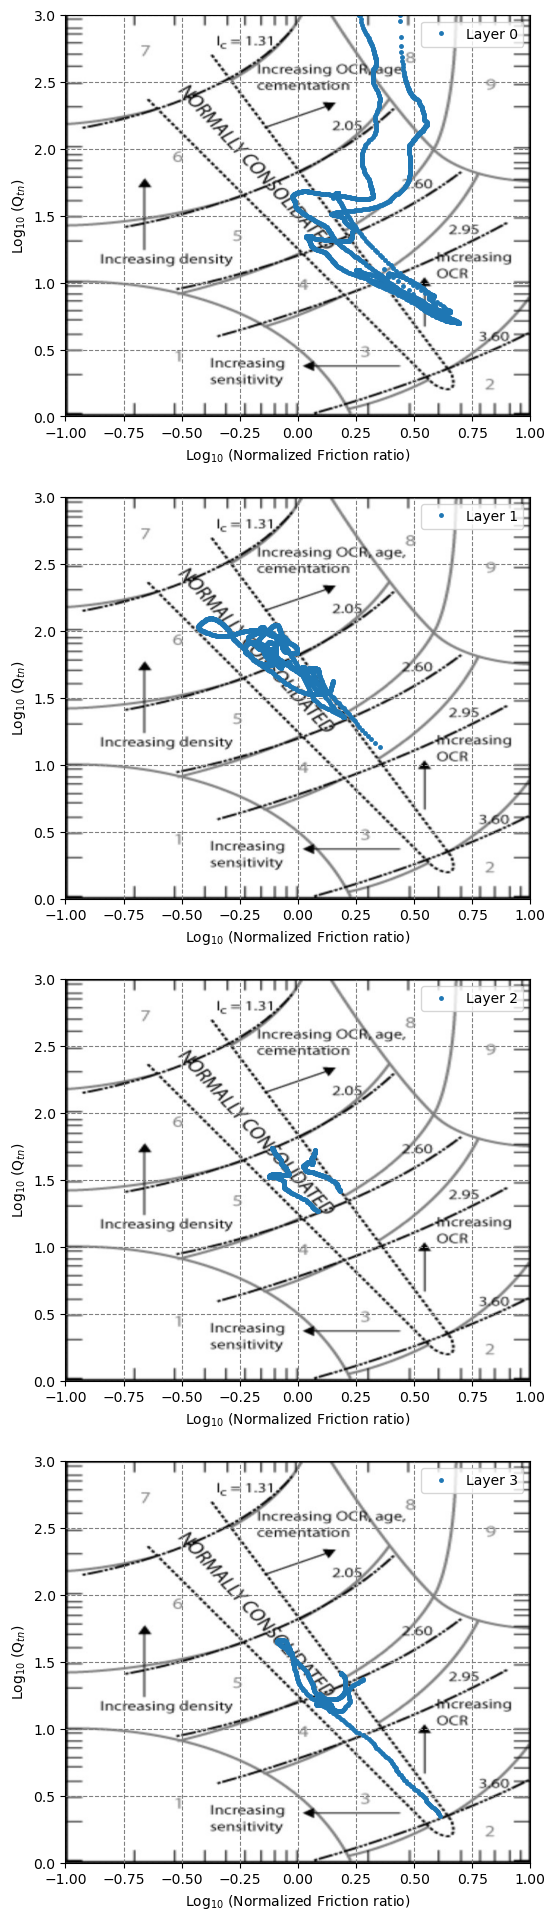

In [30]:
# Perform random forest on 2D SBTn
performRandomForestFlag = "classification" # when using 2D SBTn, must use "classification"
numberTrees = 10
maxLeafNodes = numberClusters
randomForestInput = [dataSBTn2D, numberTrees, maxLeafNodes, randomState]

randomForestObj, randomForestResult = performRandomForest(performRandomForestFlag, randomForestInput)

# plot random forest result
IcAxes = plotIc(data.iloc[:,0].to_frame(), Ic)
randomForestResultSBTn1DIc = calculateSBTn1DIc(randomForestResult) 
plotRandomForestResult(randomForestResultSBTn1DIc, dataSBTn2D, IcAxes)

# Extract layer interface depths from non-leaf nodes
randomForestCriteria = getRandomForestCriteria(randomForestObj)

# plot results by each tree using bar chart
plt.figure()
plotRandomForestCriteria(randomForestCriteria)

# reduce randomForestCriteria as median
randomForestCriteriaReduced = randomForestCriteriaMedian(randomForestCriteria)
print()
print(f"The reduced Random Forest criteria by median is: \n{randomForestCriteriaReduced}")

# reduce randomForestCriteria as majority
print()
randomForestCriteriaReduced = randomForestCriteriaMajority(randomForestCriteria)
print(f"The reduced Random Forest criteria by majority is: \n{randomForestCriteriaReduced}")

# Get strata index of each data point
randomForestStrataIndex = getStrataIndex(randomForestCriteriaReduced, dataSBTn2D)

plotSBTnAllinOne(Fr, Qtn, numberClusters, randomForestStrataIndex, SBTnImgFileName)
plt.figure()
plotSBTnAllinAll(Fr, Qtn, numberClusters, randomForestStrataIndex, SBTnImgFileName)

# END